In [41]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

import numpy as np
import torch
import matplotlib.pyplot as plt

import random

# nltk.download('punkt')
# nltk.download("stopwords")
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

In [2]:
# import requests

# link = "https://www.4icu.org/us/"
# f = requests.get(link)
# # print(f.text)

# # print(f.text)

# import re

# university_list = re.findall("<td><a href=\S+>(\D+)</a>", f.text)
# for x in range(len(university_list)):
#     curr = university_list[x]
#     if curr.lower() == "columbia university in the city of new york":
#         university_list[x] = curr[:19] 
#     if "&amp" in curr:
#         university_list[x].replace("&amp;", " ")
#         # and_index = curr.index("&")
#         # university_list[x] = curr[0:and_index] + " " + curr[and_index+5:]
#     if "The" in curr:
#         university_list[x] = curr[3:]
#     if "," in curr:
#         university_list[x].replace(",", "")

# print(len(university_list))

# top_400 = university_list[0:400]



1766


In [4]:
import requests

# link = "https://www.collegevine.com/schools/hub/overall/sheet"

link = "https://www.collegevine.com/schools/hub/data/static"

# avoid printing f.text; Large file
f = requests.get(link)


# "majorsCipCodes":["11.0701","14.0501","14.1001","14.1301","14.1901","16.0102","16.0104","16.0201",
# "16.0301","16.0302","16.0303","16.04","16.0402","16.0407","16.0408","16.0501","16.0502","16.0506",
# "16.0599","16.0701","16.09","16.0901","16.0902","16.0904","16.0905","16.1101","16.1102","16.12",
# "16.1203","16.1299","16.1301","16.1402","16.1501","23.0101","24.0101","24.0103","26.0101","26.0202",
# "26.0404","26.0406","26.0599","26.1303","26.1503","27.0101","27.0301","27.0501","3.0103","30.1301",
# "30.1701","30.1801","38.0101","38.0201","39.0601","40.0202","40.0203","40.0299","40.0501","40.0508",
# "40.0599","40.0601","40.0801","42.0101","42.2701","42.2704","45.0101","45.0201","45.0301","45.0601",
# "45.0603","45.1001","45.1101","5.0104","5.0105","5.0108","5.011","5.0112","5.0201","5.0207","5.0208",
# "5.0209","5.0299","50.0101","50.0501","50.0601","50.0702","50.0703","50.0901","51.221","54.0101",
# "54.0103","54.0104","54.0199"],"name":"Harvard University","numFreshmen"

# "majorsCipCodes":["11.0103","11.0201","11.0701","11.0801","11.1099","11.9999","13.1001","13.1203",
# "13.121","13.1302","13.1303","13.1305","13.1306","13.1307","13.1308","13.1311","13.1312","13.1314",
# "13.1316","13.1318","13.1322","13.1325","13.133","14.0701","14.0801","14.1001","14.1801","14.1901",
# "14.3501","15.0201","15.0303","15.0702","15.0805","15.1201","16.0102","16.0901","16.0902","16.0905",
# "19.0707","23.0101","23.1302","23.1303","23.1304","24.0101","24.0102","26.0101","26.0202","27.0101",
# "3.0104","30.1101","31.0501","31.0505","38.0101","38.0201","40.0201","40.0501","40.0601","40.0699",
# "40.0801","42.0101","43.0104","43.0106","44","44.0701","45.0101","45.0201","45.0601","45.0701","45.0799",
# "45.0901","45.1001","45.1101","5.0101","5.0102","5.0201","50.0399","50.0501","50.0702","50.0703","50.0901",
# "50.0902","50.0903","50.0904","50.1001","51","51.0001","51.0602","51.0701","51.0702","51.0899","51.0908",
# "51.1005","51.1504","51.2201","51.3101","51.3801","51.9999","52.0201","52.0205","52.0301","52.0304","52.0601",
# "52.0801","52.0901","52.1001","52.1002","52.1101","52.1201","52.1206","52.1302","52.1399","52.1401","52.1403",
# "52.1902","54.0101","9.0401","9.0701","9.0903","9.0906"],"name":"Youngstown State University","numFreshmen"

import re

# university_list = re.findall("\"name\":\"([^\"]+)\",\"numFreshmen\"", f.text)
university_list = re.findall("\"rankings\":.+?\"bucket\":\"(\d*)\",\"key\":\"overall\".+?\"slug\":\"(.+?)\"", f.text)

# \"slug\":\"(.+?)\"
# print(university_list[0:10])

# "\"rankings\":.+?\"order\":(\d*)(?=.+?\"key\"=\"overall\")\"slug\":\"(.+?)\""


# # \"majorsCipCodes\".+\"
# # \"numFreshmen\"

# # ([^,\"])

# # for x in range(len(university_list)):
# #     curr = university_list[x]

print(university_list[0])



('305', 'abilene-christian-university')


In [5]:
university_list = sorted(university_list, key = lambda pair: int(pair[0]))

gap = 0

for x in range(len(university_list)):
    university_list[x] = [int(university_list[x][0]), university_list[x][1]]
    if x+1 != int(university_list[x][0]) - gap:
        gap += 1
        print(university_list[x-1:x+1])

print(len(sorted(university_list, key = lambda pair: pair[0])))

top_400 = university_list[0:400]

# print(len(university_list))

# top_400 = university_list[0:400]

# print(top_400)

[[287, 'bryant-university'], [289, 'milwaukee-school-of-engineering-msoe']]
[[403, 'ohio-wesleyan-university'], [405, 'brigham-young-university-hawaii']]
[[647, 'university-of-indianapolis'], [649, 'franklin-college']]
[[676, 'st-edward-s-university'], [678, 'high-point-university']]
[[799, 'university-of-nebraska-omaha-uno'], [801, 'university-of-toledo']]
[[852, 'rocky-mountain-college-rmc'], [854, 'hardin-simmons-university']]
[[867, 'johnson-c-smith-university'], [869, 'spring-arbor-university']]
[[1053, 'tabor-college'], [1055, 'wells-college']]
[[1064, 'hope-international-university'], [1066, 'university-of-northwestern-st-paul']]
[[1191, 'concordia-college-new-york'], [1193, 'methodist-university']]
[[1264, 'notre-dame-de-namur-university'], [1266, 'felician-university']]
[[1349, 'dakota-state-university'], [1351, 'southern-university-at-new-orleans']]
1506


In [98]:
def indexToSchool(index):
    return top_400[school]

In [6]:
# testtext = "\"majorsCipCodes\":[\"11.0701\", \"11.0701\"],\"name\":\"Harvard University\",\"numFreshmen\""

# testlist = re.findall("\"majorsCipCodes\".+\"name\":\"(.*)\",\"numFreshmen\"", testtext)

# print(testlist)

['Harvard University']


In [7]:
# get links for all schools

college_links = []

for school in top_400:
    name = school[1]
    college_links.append("https://www.collegevine.com/schools/" 
                            + name.replace(" ", "-") 
                            +  "/essay-prompts")

print(college_links[0])

https://www.collegevine.com/schools/stanford-university/essay-prompts


In [9]:
# test_link = "https://www.collegevine.com/schools/harvard-university/essay-prompts"

# f = requests.get(test_link)
# # print(f.text)

# titles = re.findall("<h3 class='mt-2'>(.+?)</h3>", f.text)
# prompts = re.findall("<p>(.+?)</p>", f.text)[0:-7]
# # titles = re.findall("<h3 class='mt-2'>(.+?)</h3>[\S\s]+?<p>(.+?)</p>", f.text)[0:-1]
# print(prompts)

# select_prompts = re.findall("</h5>\s<p>\s<p>(.+?)</p>", f.text)
# print(select_prompts)


# if prompts == []:
#     potential_issues.append(link)

# if len(titles) != len(prompts)-7:
#     print(len(titles))
#     print(len(prompts))
#     print(link)

In [10]:
# access links
# allprompts = []

# potential_issues = []
# shift = 0

# for link in college_links:
#     f = requests.get(link)

#     titles = re.findall("<h3 class='mt-2'>(.+?)</h3>", f.text)
#     prompts = re.findall("<p>(.+?)</p>", f.text)
#     # print(titles)
#     if titles[-1] == "Common App Personal Essay":
#         titles = titles[:-1]
#         prompts = prompts[:-8]
    
#     if "Select-A-Prompt Short Response" in titles:
#         select_prompt_ind = titles.index("Select-A-Prompt Short Response")
#         del titles[select_prompt_ind]
#         del prompts[select_prompt_ind]

#         select_prompts = re.findall("<h5>(.+?)</h5>", f.text)
#         for x in select_prompts:
#             titles.append("Select-A-Prompt")
#             prompts.append(x)



#     allprompts.append(prompts)

#     if prompts == []:
#         potential_issues.append(link)

#     if len(titles) != len(prompts):
#         print(link)

# print(potential_issues)

# print(college_links[333])

# temp_f = requests.get(college_links[323])

# prompts = re.findall("<p>(.+)</p>", temp_f.text)
# print(prompts)


In [8]:
# obtain word bag

def get_bag(docs, word_list):
    out_list = []

    for doc in docs:
        stop_words = set(stopwords.words("english") + ["etc", "'s", ""])
        filtered_list = []

        seperated_words = word_tokenize(doc[1])

        for word in seperated_words:
            # currently deciding to filter out punctuation
            if word[-1] in [".", ",", ";", ":", "?", "!", "*", "’", "–"]:
                word = word[:-1]
            if word not in stop_words:
                # currently ignoring capitalization
                filtered_list.append(word.lower())
        
        # filtered_list = [word for word in doc[1].split() if word not in stop_words]
        tagged_list = nltk.pos_tag(filtered_list)
        
        lemmatizer = WordNetLemmatizer()
        lemmatized_list = []

        for word in tagged_list:
            pos = ""
            # print(word[1][0])
            if word[1][0] == "J":
                pos = "a"
            elif word[1][0] == "N":
                pos = "n"
            elif word[1][0] == "V":
                pos = "v"
            elif word[1][0] == "R":
                pos = "r"
            else:
                # print("uh oh")
                lemmatized_list.append(word[0])
                continue
            
            lemmatized_list.append(lemmatizer.lemmatize(word[0], pos=pos))

        word_list += lemmatized_list
        out_list.append(lemmatized_list)
        
    return out_list, word_list

In [25]:
# nlp processing

# def process(docs, word_dictionary):
#     print("e")
#     for doc in docs:
#         print(doc)
#         curr_vector = []
#         for word in doc.split():
#             if word in word_dictionary.keys():
#                 word_dictionary[word] += 1
    


In [99]:
# access links and create general word bag


# currently trying to use list instead of dictionary to store prompts and their corresponding index
allprompts = []
prompt_matrix = []

potential_issues = []
index = 0
prompts = []
has_common_app = False
word_list = []

for link_index in range(len(college_links)):
    has_common_app = False
    link = college_links[link_index]
    f = requests.get(link)

    noprompts = re.search("<h2>", f.text)

    if not bool(noprompts):
        prompts = re.findall("<h3 class='mt-2'>(.+?)</h3>[\S\s]+?<p>(.+?)</p>", f.text)
        select_prompts = re.findall("</h5>\s<p>\s<p>(.+?)</p>", f.text)

        if prompts == []:
            potential_issues.append(link)
            continue

        if prompts[-1][0] == "Common App Personal Essay":
            has_common_app = True
            prompts = prompts[:-1]
            select_prompts = select_prompts[:-7]

        if select_prompts != []:
            i = 0
            while i < len(prompts):
                # print(len(prompts[x]))
                if "Select-A-Prompt" in prompts[i][0]:
                    del prompts[i]
                else:
                    i += 1

            if has_common_app:
                for x in select_prompts:
                    prompts.append(("Select-A-Prompt", x))

        # checks again, but now for schools with only common app essay
        if prompts == []:
            continue
        
        # prompts is a list of prompts for the current school.
        # each prompt is in a tuple with their title first and then the prompt
        allprompts.append([link_index, prompts])

        prompts, word_list = get_bag(prompts, word_list)
        
        # school_rank = top_400[link_index][0]
        
        for j in range(len(prompts)):
            prompt_matrix.append([index, j] + prompts[j])
        
        index += 1

        # allprompts.append([[link_index] + prompts[j] for j in range(len(prompts))])

In [100]:
print(prompt_matrix[5])

[0, 5, 'what', 'historical', 'moment', 'event', 'wish', 'could', 'witness']


In [42]:
# single case testing

has_common_app = False
link = "https://www.collegevine.com/schools/stanford-university/essay-prompts"
f = requests.get(link)

noprompts = re.search("<h2>", f.text)
allprompts = {}
word_list = []

for link_index in range(1,2):
    if not bool(noprompts):
        prompts = re.findall("<h3 class='mt-2'>(.+?)</h3>[\S\s]+?<p>(.+?)</p>", f.text)
        select_prompts = re.findall("</h5>\s<p>\s<p>(.+?)</p>", f.text)

        if prompts == []:
            potential_issues.append(link)
            break

        if prompts[-1][0] == "Common App Personal Essay":
            has_common_app = True
            prompts = prompts[:-1]
            select_prompts = select_prompts[:-7]

        if select_prompts != []:
            i = 0
            while i < len(prompts):
                # print(len(prompts[x]))
                if "Select-A-Prompt" in prompts[i][0]:
                    del prompts[i]
                else:
                    i += 1

            if has_common_app:
                for x in select_prompts:
                    prompts.append(("Select-A-Prompt", x))

        word_list = get_bag(prompts, word_list)

        school_rank = top_400[link_index][0]
        allprompts[school_rank] = prompts


print(word_list[0:100])

([['the', 'stanford', 'community', 'deeply', 'curious', 'driven', 'learn', 'classroom', 'reflect', 'idea', 'experience', 'make', 'genuinely', 'excited', 'learning'], ['virtually', 'stanford', 'undergraduate', 'live', 'campus', 'write', 'note', 'future', 'roommate', 'reveals', 'something', 'help', 'roommate', 'us', 'get', 'know', 'good'], ['tell', 'us', 'something', 'meaningful'], ['what', 'significant', 'challenge', 'society', 'face', 'today'], ['how', 'spend', 'last', 'two', 'summer'], ['what', 'historical', 'moment', 'event', 'wish', 'could', 'witness'], ['briefly', 'elaborate', 'one', 'extracurricular', 'activity', 'job', 'hold', 'responsibility', 'family'], ['name', 'one', 'thing', 'look', 'forward', 'experience', 'stanford']], ['the', 'stanford', 'community', 'deeply', 'curious', 'driven', 'learn', 'classroom', 'reflect', 'idea', 'experience', 'make', 'genuinely', 'excited', 'learning', 'virtually', 'stanford', 'undergraduate', 'live', 'campus', 'write', 'note', 'future', 'roommat

In [101]:
len(potential_issues)

print(potential_issues)

[]


In [102]:
print(allprompts[0])

[0, [('Intellectual Passion Short Response', 'The Stanford community is deeply curious and driven to learn in and out of the classroom. Reflect on an idea or experience that makes you genuinely excited about learning.*'), ('Roommate Short Response', "Virtually all of Stanford's undergraduates live on campus. Write a note to your future roommate that reveals something about you or that will help your roommate – and us – get to know you better.*"), ('Share Something Meaningful Short Response', 'Tell us about something that is meaningful to you and why.*'), ('Societal Challenge Short Response', 'What is the most significant challenge that society faces today?'), ('Summer Activities Short Response', 'How did you spend your last two summers?'), ('Historical Moment Short Response', 'What historical moment or event do you wish you could have witnessed?'), ('Extracurricular Short Response', 'Briefly elaborate on one of your extracurricular activities, a job you hold, or responsibilities you ha

In [60]:
print(len(word_list), len(set(word_list)))

print(word_list[0:100])

12758 2458
['the', 'stanford', 'community', 'deeply', 'curious', 'driven', 'learn', 'classroom', 'reflect', 'idea', 'experience', 'make', 'genuinely', 'excited', 'learning', 'virtually', 'stanford', 'undergraduate', 'live', 'campus', 'write', 'note', 'future', 'roommate', 'reveals', 'something', 'help', 'roommate', 'us', 'get', 'know', 'good', 'tell', 'us', 'something', 'meaningful', 'what', 'significant', 'challenge', 'society', 'face', 'today', 'how', 'spend', 'last', 'two', 'summer', 'what', 'historical', 'moment', 'event', 'wish', 'could', 'witness', 'briefly', 'elaborate', 'one', 'extracurricular', 'activity', 'job', 'hold', 'responsibility', 'family', 'name', 'one', 'thing', 'look', 'forward', 'experience', 'stanford', 'your', 'intellectual', 'life', 'may', 'extend', 'beyond', 'academic', 'requirement', 'particular', 'school', 'please', 'use', 'space', 'list', 'additional', 'intellectual', 'activity', 'mention', 'detail', 'elsewhere', 'application', 'these', 'could', 'include', '

In [61]:
for i in range(len(top_400)):
    if i == 384:
        print(top_400[i])

[386, 'birmingham-southern-college-bsc']


In [14]:
alltitles = []

for link in college_links:
    f = requests.get(link)

    titles = re.findall("<h3 class='mt-2'>(.+?)</h3>", f.text)
    alltitles += titles

alltitles = set(alltitles)

print(len(alltitles))


230


In [16]:
print(list(alltitles)[0:10])

['Questions for Us Short Response', 'M&amp;T Program Essay', 'Service-Based Gap Year Short Response', 'Academic Short Response', 'Overcoming Challenges Essay', 'School of Nursing and Health Studies Essay', 'Select-A-Prompt Essay', 'Morrill Scholarship Program Short Response', 'Design BA/BFA Applicants Essay', 'This or That Short Response']


In [103]:
# turn prompts into vectors

for prompt_ind in range(len(prompt_matrix)):
    curr_freq = dict(zip(word_list, [0 for x in range(len(word_list))]))
    for word in prompt_matrix[prompt_ind][2:]:
        curr_freq[word] += 1
    prompt_matrix[prompt_ind] = prompt_matrix[prompt_ind][0:2] + list(curr_freq.values())

In [ ]:
print(prompt_matrix[0])

In [105]:
# print(allprompts[17])
# prompt_matrix = []

# for prompt in allprompts:
# 
#     for prompt in prompts:
#         prompt_matrix.append(prompt)

prompt_tensor = torch.tensor(prompt_matrix, dtype=torch.float32)

print(prompt_tensor.shape)

torch.manual_seed(333)
U, S, V = torch.pca_lowrank(prompt_tensor[:,2:], q=None, center=True, niter=3)

pca_axes = torch.matmul(prompt_tensor[:,2:], V[:, :7])

torch.Size([728, 2460])


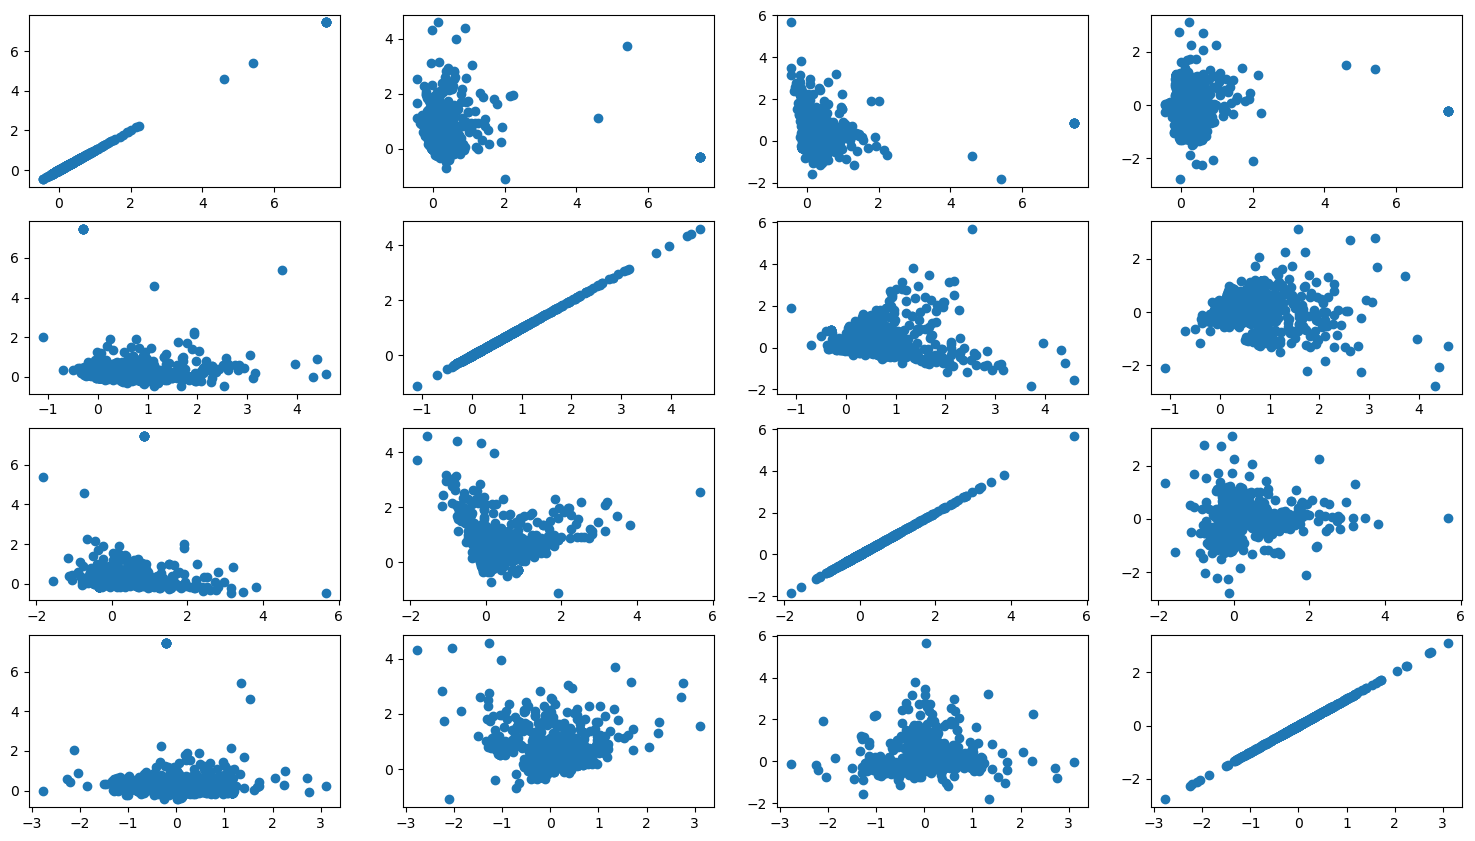

In [106]:
# print(pca_axes[...,0])
# print(max(pca_axes[:,0]))


# combo plot
num_comps = 4

fig, axs = plt.subplots(num_comps, num_comps)

fig.set_size_inches(18.5, 10.5, forward=True)

fig.set_dpi(100)

for i in range(0, num_comps):
    for j in range(0, num_comps):
        axs[i][j].scatter(pca_axes[:,i], pca_axes[:,j])

# interesting note: almost all the plots have a central clump and then one or more very pronounced arms
# need to consider whether PCA is meaningful for nlp clustering


# # single plot

# fig = plt.figure(figsize=(20,20))
# plt.scatter(pca_axes[:,0], pca_axes[:,1], s=20)

# fig.set_dpi(100)

In [18]:
# k means clustering from scratch
# 2D ONLY

# import random

# def find_distances(xvals, yvals, centroids):
#     clusters = [[] for x in range(len(centroids))]

#     for i in range(len(xvals)):
#         curr_point = [xvals[i], yvals[i]]

#         # should be large enough given that words will rarely 
#         #   occur more than even 20 times in one prompt
#         min_dist = 100000
#         min_ind = -1
#         for j in range(len(centroids)):
#             # print(centroids[j])
#             curr_dist = sum(abs(centroids[j] - curr_point)) ** 0.5
#             # print(curr_dist)
#             if curr_dist < min_dist:
#                 min_dist = curr_dist
#                 min_ind = j
        
#         # print(min_ind)
#         clusters[min_ind].append(curr_point)

#     return clusters


# def k_means(xvals, yvals, k):
#     centroids = []

#     random.seed(333)

#     for center_num in range(k):
#         index = random.randrange(0, len(xvals))
#         coordinate = np.asarray([xvals[index], yvals[index]])
#         centroids.append(coordinate)
    
#     # print(centroids)
#     equal_means = 0
#     clusters = []

#     while equal_means < k:
#         clusters = find_distances(xvals, yvals, centroids)
#         # print(len(clusters))
#         for i in range(k):
#             mean = sum(np.asarray(clusters[i])) / len(clusters[i])
#             # print(mean)
#             if (mean[0] != centroids[i][0]) and (mean[1] != centroids[i][1]):
#                 centroids[i] = mean
#             else:
#                 equal_means += 1
    
#     return clusters


In [107]:
# k-means for any dim, points is list of vectors in n-dim

def find_distances(points, centroids, labels = []):
    clusters = [[] for x in range(len(centroids))]

    for curr_point in points:

        # should be large enough given that words will rarely 
        #   occur more than even 20 times in one prompt
        min_dist = 100000000
        min_ind = len(centroids)
        for j in range(len(centroids)):
            curr_dist = sum((centroids[j] - curr_point) ** 2) ** 0.5
            if curr_dist < min_dist:
                min_dist = curr_dist
                min_ind = j
        
        # print(min_ind)
        clusters[min_ind].append(curr_point)

    return clusters


def k_means(points, k):

    random.seed(333)
    centroids = random.sample(points, k)

    for center_num in range(k):
        centroids[center_num] = np.asarray(centroids[center_num])
    
    # print(centroids)
    equal_means = 0
    clusters = []

    while equal_means < k:
        clusters = find_distances(points, centroids)
        # print(len(clusters))
        for i in range(k):
            mean = sum(np.asarray(clusters[i])) / len(clusters[i])
            # print(mean)
            dim = 0
            curr_equal_means = True
            while (dim < len(points[0])) and curr_equal_means:
                if (mean[dim] != centroids[i][dim]):
                    centroids[i] = mean
                    curr_equal_means = False
                dim += 1
            
            if dim == len(points[0]):
                equal_means += 1
    
    return clusters

51


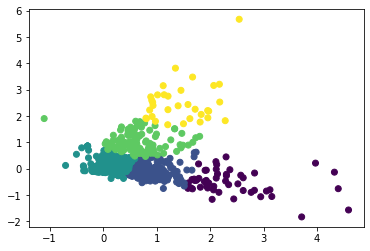

In [108]:
pca_points = [[pca_axes[:,1][i], pca_axes[:,2][i]] for i in range(len(pca_axes[:,1]))]

pca_clusters = k_means(pca_points, 5)

print(len(pca_clusters[0]))

pca_clusters_graph = []

for c in range(len(pca_clusters)):
    for x in pca_clusters[c]:
        pca_clusters_graph.append(x + [c])

pca_clusters_graph = np.asarray(pca_clusters_graph)

plt.scatter(pca_clusters_graph[:,0], pca_clusters_graph[:,1], c = pca_clusters_graph[:,2])

In [121]:
all_clusters = k_means(prompt_matrix, 40)

for x in all_clusters:
    print(len(x))

1
8
17
25
13
33
26
20
19
27
1
10
18
20
15
21
1
1
2
14
19
36
39
7
47
22
13
24
2
10
7
33
4
15
54
19
34
34
16
1


In [123]:
for x in all_clusters[38:39]:
    print(len(x))
    for i in range(0, len(x), 1):
        school_ind = x[i][0]
        prompt_ind = x[i][1]
        print(top_400[allprompts[school_ind][0]], allprompts[school_ind][1][prompt_ind])


16
[2, 'harvard-university'] ('Select-A-Prompt', 'The mission of Harvard College is to educate our students to be citizens and citizen-leaders for society. What would you do to contribute to the lives of your classmates in advancing this mission? ')
[2, 'harvard-university'] ('Select-A-Prompt', 'Each year a substantial number of students admitted to Harvard defer their admission for one year or take time off during college. If you decided in the future to choose either option, what would you like to do? ')
[2, 'harvard-university'] ('Select-A-Prompt', 'Harvard has long recognized the importance of student body diversity of all kinds. We welcome you to write about distinctive aspects of your background, personal development or the intellectual interests you might bring to your Harvard classmates. ')
[4, 'princeton-university'] ('Select-A-Prompt', 'What brings you joy? ')
[4, 'princeton-university'] ('Select-A-Prompt', 'What song represents the soundtrack of your life at this moment?')
[

In [ ]:
# to-do 
# [X] conda env export > environment.yml 
# [?] incorporate select-a-prompts
# [?] check for weird symbols, i.e. "&amp"
# [*] use nltk to process prompts
# [] look into tf-idf
# [] download matplotlib on school computer
# [*] clustering
#  - - [x] k-means based on euclidean dist
#  - - [] k-means based on cosine similarity?
#  - - [] hierarchical
# [] commit and push yml file to remote (!!!)
# [?] create list translating between ranking and name, basically watch out for 288 and maybe 404
#  - - [] use array instead of dictionary for allprompts? if looking for original, just use index...